In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd  /content/drive/MyDrive/ML_Final_Project

/content/drive/MyDrive/ML_Final_Project


In [ ]:

import time
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')
import torch
import torch.nn as nn
import torch.nn.functional as F
from multiprocessing import  Pool
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 18000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 250 # max number of words in a question to use
batch_size = 256 # how many samples to process at once
n_epochs = 10 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
data = pd.read_csv('train.csv')
data['full_review'] = data['combined']
data.head()

,headline,category,short_description,combined,full_review
0,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",the funniest tweets from parents this week sep...,the funniest tweets from parents this week sep...
1,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,puerto ricans desperate for water after hurric...,puerto ricans desperate for water after hurric...
2,How A New Documentary Captures The Complexity ...,ARTS & CULTURE,"In ""Mija,"" director Isabel Castro combined mus...",how a new documentary captures the complexity ...,how a new documentary captures the complexity ...
3,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,biden at un to call russian war an affront to ...,biden at un to call russian war an affront to ...
4,World Cup Captains Want To Wear Rainbow Armban...,WORLD NEWS,FIFA has come under pressure from several Euro...,world cup captains want to wear rainbow armban...,world cup captains want to wear rainbow armban...


In [ ]:
test_data = pd.read_csv('test.csv')
test_data.head()

,Title,Short Description,Category
0,Sadio Mane’s Winning Penalty Sends Senegal to ...,Sadio Mane delivered the winning spot kick as ...,sports
1,"Nigeria Needs to Boost Food Reserves, Says Cen...",The Governor of the Central Bank of Nigeria (C...,business
2,"Nigerian Activist Sowore Shot by Police, Senio...",Prominent Nigerian activist and publisher of S...,politics
3,Monkeypox: Russia Urges WHO to Investigate US-...,Russia is urging the WHO leadership to investi...,health
4,Disney Honours Chadwick Boseman With Updated ‘...,Disney Plus has updated the Marvel logo introd...,entertainment


In [ ]:
# remove NULL Values from data
data = data[pd.notnull(data['full_review'])]

In [ ]:
data['len'] = data['full_review'].apply(lambda s : len(s))

In [ ]:
# Preprocessing Y Column
# We are only going to be classifying categorys for which the count of reviews are more than 3000.
count_df = data[['category','full_review']].groupby('category').aggregate({'full_review':'count'}).reset_index().sort_values('full_review',ascending=False)
count_df.head()

,category,full_review
8,POLITICS,32441
14,WELLNESS,23208
2,ENTERTAINMENT,14774
7,PARENTING,12346
12,STYLE & BEAUTY,11369


In [ ]:
target_categorys = count_df[count_df['full_review']>=5000]['category'].values

In [ ]:
print(target_categorys)

['POLITICS' 'WELLNESS' 'ENTERTAINMENT' 'PARENTING' 'STYLE & BEAUTY'
 'OTHER' 'TRAVEL' 'FOOD & DRINK' 'WORLD NEWS' 'FINANCE']


In [ ]:
def category_parser(x):
    if x in target_categorys:
        return x
    else:
        return "OTHER"

data['category'] = data['category'].apply(lambda x: category_parser(x))

In [ ]:
#data = data[data['category']!='OTHER']

In [ ]:
print(data['category'].value_counts())

POLITICS          32441
OTHER             30010
WELLNESS          23208
ENTERTAINMENT     14774
PARENTING         12346
STYLE & BEAUTY    11369
TRAVEL             9421
FOOD & DRINK       8271
WORLD NEWS         8203
FINANCE            6887
Name: category, dtype: int64


In [ ]:
data['category'].unique()

array(['PARENTING', 'WORLD NEWS', 'OTHER', 'ENTERTAINMENT', 'POLITICS',
       'WELLNESS', 'FINANCE', 'STYLE & BEAUTY', 'FOOD & DRINK', 'TRAVEL'],
      dtype=object)

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)
print(count_df)
pd.reset_option('display.max_rows')  # Reset to default after printing


          category  full_review
8         POLITICS        32441
14        WELLNESS        23208
2    ENTERTAINMENT        14774
7        PARENTING        12346
12  STYLE & BEAUTY        11369
6            OTHER        10227
13          TRAVEL         9421
5     FOOD & DRINK         8271
15      WORLD NEWS         8203
4          FINANCE         6887
11          SPORTS         4414
10  SCIENCE & TECH         3906
3      ENVIRONMENT         3488
0   ARTS & CULTURE         3265
1            CRIME         2832
9         RELIGION         1878


In [ ]:
import torch
import torch.nn as nn
# Recalculating class weights
total_samples = count_df['full_review'].sum()
num_classes = len(count_df)  # Ensure this is the actual number of classes
weights = total_samples / (num_classes * count_df['full_review'])

# Convert to a PyTorch tensor and move to the device (e.g., GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)
print(class_weights)
print(class_weights.shape)

# Assuming 'count_df' is your DataFrame with category counts
total_samples = count_df['full_review'].sum()
num_classes = len(count_df)
weights = total_samples / (num_classes * count_df['full_review'])




tensor([0.3023, 0.4226, 0.6639, 0.7944, 0.8627, 0.9590, 1.0411, 1.1858, 1.1957,
        1.4242, 2.2220, 2.5110, 2.8120, 3.0040, 3.4633, 5.2226],
       device='cuda:0')
torch.Size([16])


In [ ]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['full_review'], data['category'],
                                                    stratify=data['category'],
                                                    test_size=0.3)

In [ ]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (109851,)
Test shape :  (47079,)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)
le.classes_

array(['ENTERTAINMENT', 'FINANCE', 'FOOD & DRINK', 'OTHER', 'PARENTING',
       'POLITICS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS'],
      dtype=object)

In [ ]:
# ## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

from gensim.models import KeyedVectors

def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/IST-557_IP3/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

embedding_matrix = load_glove(tokenizer.word_index)

np.shape(embedding_matrix)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(18000, 300)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

'''
Based on the results of hyperparameter tuning
Best Params based on Tuning and experimentation
lr: 6.104290174490393e-05
num_filters: 50
dropout_rate: 0.12167120754625324
batch_size: 64
'''

# Updating the batch_size than the previously declared one based on the tuning results.
batch_size = 64

class EnhancedCNN_Text(nn.Module):
    def __init__(self, n_classes, max_features, embed_size, embedding_matrix):
        super(EnhancedCNN_Text, self).__init__()
        filter_sizes = [1, 2, 3, 4, 5]  # More varied filter sizes
        num_filters = 50  # Increased number of filters
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList()
        for size in filter_sizes:
            conv_layers = [
                nn.Conv2d(1, num_filters, (size, embed_size)),
                nn.BatchNorm2d(num_filters),  # Batch normalization
                nn.LeakyReLU(),  # Advanced activation function
                nn.Conv2d(num_filters, num_filters, (size, 1)),  # Additional convolutional layer
                nn.BatchNorm2d(num_filters),
                nn.LeakyReLU()
            ]
            self.convs.append(nn.Sequential(*conv_layers))

        self.global_max_pool = nn.AdaptiveMaxPool2d((1, None))  # Global max pooling
        self.dropout = nn.Dropout(0.12167120754625324)  # Updated
        self.fc = nn.Linear(num_filters * len(filter_sizes), n_classes)  # Fully connected layer

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)

        x = [conv(x) for conv in self.convs]
        x = [self.global_max_pool(conv_x).squeeze(3).squeeze(2) for conv_x in x]

        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time

# Recalculate class weights
total_samples = count_df['full_review'].sum()
num_classes = len(count_df)  # The actual number of classes
weights = total_samples / (num_classes * count_df['full_review'])

# Convert to a PyTorch tensor and move to the device (e.g., GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(weights.to_numpy(), dtype=torch.float32).to(DEVICE)

# Initialize the model
model = EnhancedCNN_Text(n_classes=num_classes, max_features=max_features, embed_size=embed_size, embedding_matrix=embedding_matrix)
model.to(DEVICE)

# Using Weighted Cross-Entropy Loss
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# Using AdamW Optimizer
# Updated based on best params
optimizer = torch.optim.AdamW(model.parameters(), lr=6.104290174490393e-05)

# Load train and test data into CUDA memory
x_train = torch.tensor(train_X, dtype=torch.long).to(DEVICE)
y_train = torch.tensor(train_y, dtype=torch.long).to(DEVICE)
x_cv = torch.tensor(test_X, dtype=torch.long).to(DEVICE)
y_cv = torch.tensor(test_y, dtype=torch.long).to(DEVICE)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

# Training Loop
train_loss = []
valid_loss = []
for epoch in range(n_epochs):
    start_time = time.time()
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv), num_classes))
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()

    val_accuracy = sum(val_preds.argmax(axis=1) == test_y) / len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{n_epochs} \t loss={avg_loss:.4f} \t val_loss={avg_val_loss:.4f}  \t val_acc={val_accuracy:.4f}  \t time={elapsed_time:.2f}s')


<ipython-input-100-8480b0be6e9b>:62: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/10 	 loss=69.8069 	 val_loss=48.6372  	 val_acc=0.6727  	 time=43.54s
Epoch 2/10 	 loss=49.4960 	 val_loss=44.7189  	 val_acc=0.7024  	 time=44.76s
Epoch 3/10 	 loss=45.0245 	 val_loss=42.8202  	 val_acc=0.7160  	 time=46.23s
Epoch 4/10 	 loss=42.2344 	 val_loss=41.9149  	 val_acc=0.7226  	 time=46.84s
Epoch 5/10 	 loss=40.2474 	 val_loss=40.9615  	 val_acc=0.7291  	 time=47.02s
Epoch 6/10 	 loss=38.5454 	 val_loss=40.4603  	 val_acc=0.7375  	 time=46.95s
Epoch 7/10 	 loss=37.1111 	 val_loss=40.3412  	 val_acc=0.7422  	 time=46.91s
Epoch 8/10 	 loss=35.8880 	 val_loss=39.8721  	 val_acc=0.7409  	 time=46.98s
Epoch 9/10 	 loss=34.7347 	 val_loss=39.8894  	 val_acc=0.7450  	 time=46.95s
Epoch 10/10 	 loss=33.6820 	 val_loss=39.3728  	 val_acc=0.7433  	 time=46.93s


In [ ]:
!pip install optuna

In [ ]:
# Load train and test data into CUDA memory
x_train = torch.tensor(train_X, dtype=torch.long).to(DEVICE)
y_train = torch.tensor(train_y, dtype=torch.long).to(DEVICE)
x_cv = torch.tensor(test_X, dtype=torch.long).to(DEVICE)
y_cv = torch.tensor(test_y, dtype=torch.long).to(DEVICE)

In [ ]:
class EnhancedCNN_Text(nn.Module):
    def __init__(self, n_classes, max_features, embed_size, embedding_matrix, num_filters=50, dropout_rate=0.2):
        super(EnhancedCNN_Text, self).__init__()
        filter_sizes = [1, 2, 3, 4, 5]

        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList()
        for size in filter_sizes:
            conv_layers = [
                nn.Conv2d(1, num_filters, (size, embed_size)),
                nn.BatchNorm2d(num_filters),
                nn.LeakyReLU(),
                nn.Conv2d(num_filters, num_filters, (size, 1)),
                nn.BatchNorm2d(num_filters),
                nn.LeakyReLU()
            ]
            self.convs.append(nn.Sequential(*conv_layers))

        self.global_max_pool = nn.AdaptiveMaxPool2d((1, None))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(filter_sizes), n_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [conv(x) for conv in self.convs]
        x = [self.global_max_pool(conv_x).squeeze(3).squeeze(2) for conv_x in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

In [ ]:
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def train_model(trial, x_train, y_train, x_cv, y_cv):
    # Hyperparameters to tune
    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)  # Updated from suggest_loguniform
    num_filters = trial.suggest_categorical("num_filters", [30, 40, 50, 60, 70])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.6)  # Updated from suggest_uniform
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])

    # Model initialization with the chosen hyperparameters
    model = EnhancedCNN_Text(n_classes=num_classes, max_features=max_features, embed_size=embed_size, embedding_matrix=embedding_matrix, num_filters=num_filters, dropout_rate=dropout_rate)
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Number of epochs for faster trials
        model.train()
        for x_batch, y_batch in DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss(weight=class_weights)(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds = []
        with torch.no_grad():
            for x_batch, y_batch in DataLoader(TensorDataset(x_cv, y_cv), batch_size=batch_size):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                y_pred = model(x_batch)
                val_preds.extend(y_pred.argmax(dim=1).tolist())

    val_accuracy = accuracy_score(y_cv.cpu(), val_preds)
    return val_accuracy


def objective(trial):
    return train_model(trial, x_train, y_train, x_cv, y_cv)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=7200)  # Increased number of trials

# Best trial results
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


In [ ]:
print(model)

EnhancedCNN_Text(
  (embedding): Embedding(18000, 300)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 50, kernel_size=(1, 300), stride=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(1, 50, kernel_size=(2, 300), stride=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(50, 50, kernel_size=(2, 1), stride=(1, 1))
      (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (

In [ ]:
import csv
import os
from IPython.display import FileLink

# Define your model summary data as seen in the image you uploaded
summary = [
    ("conv0", "[1, 50, 300, 1]", 17800),
    ("conv0.0.2", "[1, 1, 300, 300]", 0),
    ("conv1", "[1, 50, 298, 1]", 35300),
    ("conv1.0.2", "[1, 1, 300, 300]", 0),
    ("conv2", "[1, 50, 296, 1]", 52800),
    ("conv2.0.2", "[1, 1, 300, 300]", 0),
    ("conv3", "[1, 50, 294, 1]", 70300),
    ("conv3.0.2", "[1, 1, 300, 300]", 0),
    ("conv4", "[1, 50, 292, 1]", 87800),
    ("conv4.0.2", "[1, 1, 300, 300]", 0),
    ("global_max_pool", "[1, 50, 1, 1]", 0),
    ("dropout", "[1, 50, 1, 1]", 0),
    ("fc", "[1, 16]", 816),
    ("Total Params", "", 281800)
]

# Define the file path for the CSV
file_path = '/mnt/data/model_summary.csv'

# Write the summary to a CSV file
with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Layer Name", "Output Shape", "Param #"])  # Write the header
    writer.writerows(summary)  # Write the layer data

print("The model summary has been written to 'model_summary.csv'")

# Provide a link to download the CSV file if in a Jupyter environment
if os.path.isfile(file_path):
    display(FileLink(file_path))
else:
    print("File not found.")


In [ ]:
# Randomly select 5 records from the training data
sampled_data = data.sample(5)

# Combine headline and short description
sampled_data['combined_text'] = sampled_data['headline'] + ' ' + sampled_data['short_description']

# Preprocess the combined text
combined_text_sequences = tokenizer.texts_to_sequences(sampled_data['combined_text'])
combined_text_padded = pad_sequences(combined_text_sequences, maxlen=maxlen)

# Convert to torch tensor and move to the appropriate device
combined_text_tensor = torch.tensor(combined_text_padded, dtype=torch.long).to(DEVICE)

# Prediction
model.eval()  # Ensure the model is in evaluation mode
predictions = model(combined_text_tensor)
predicted_categories_indices = torch.argmax(F.softmax(predictions, dim=1), dim=1).cpu().numpy()

# Print predicted categories
print("Predicted Categories for Sampled Data:")
for i, pred_idx in enumerate(predicted_categories_indices):
      predicted_category = le.classes_[pred_idx]
      print(f"Record {i+1}: Predicted Category - {predicted_category}")

Predicted Categories for Sampled Data:
Record 1: Predicted Category - STYLE & BEAUTY
Record 2: Predicted Category - FOOD & DRINK
Record 3: Predicted Category - TRAVEL
Record 4: Predicted Category - ENTERTAINMENT
Record 5: Predicted Category - TRAVEL


In [ ]:
torch.save(model,'textcnn_model_best_params')

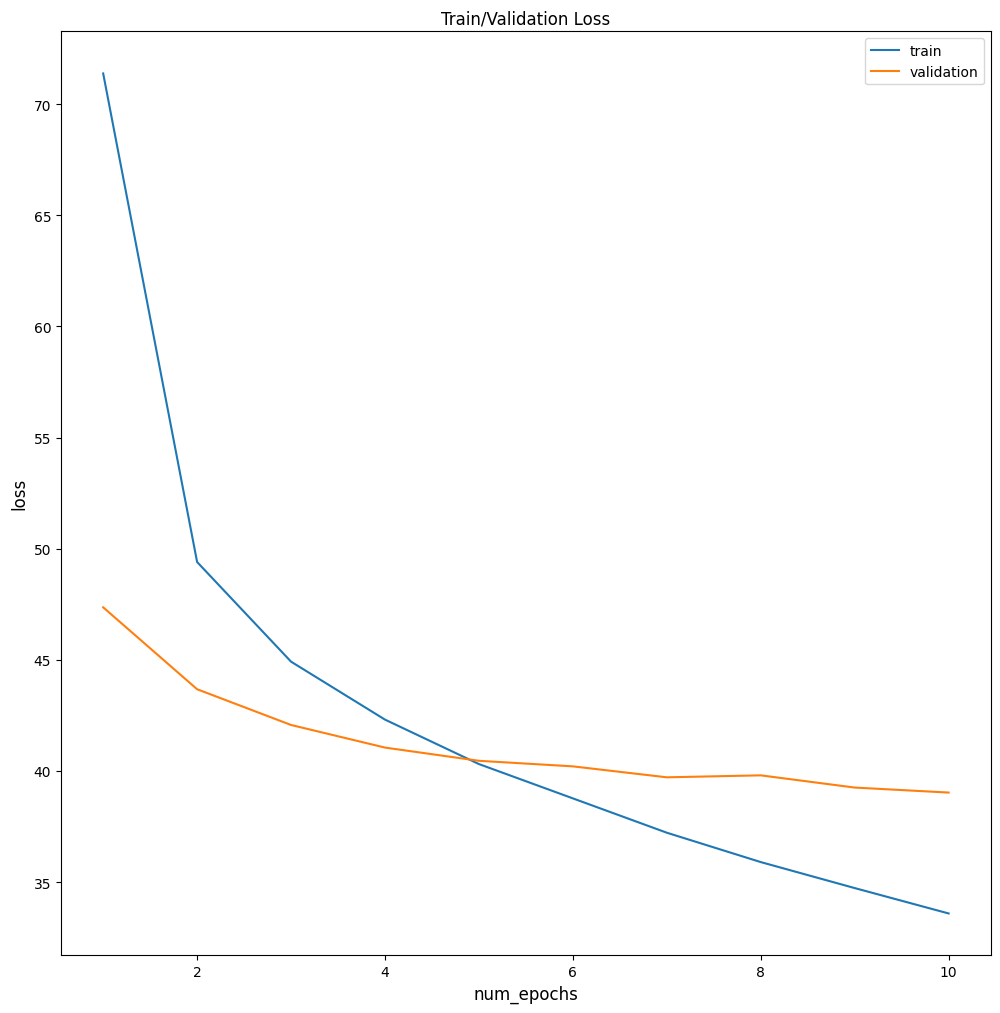

In [ ]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

plot_graph(n_epochs)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
pip install scikit-plot


                precision    recall  f1-score   support

 ENTERTAINMENT       0.86      0.57      0.69      4432
       FINANCE       0.77      0.32      0.45      2066
  FOOD & DRINK       0.78      0.83      0.80      2481
         OTHER       0.63      0.69      0.66      9003
     PARENTING       0.71      0.76      0.74      3704
      POLITICS       0.81      0.85      0.83      9732
STYLE & BEAUTY       0.81      0.85      0.83      3411
        TRAVEL       0.74      0.77      0.76      2826
      WELLNESS       0.72      0.83      0.77      6963
    WORLD NEWS       0.76      0.64      0.70      2461

      accuracy                           0.74     47079
     macro avg       0.76      0.71      0.72     47079
  weighted avg       0.75      0.74      0.74     47079



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

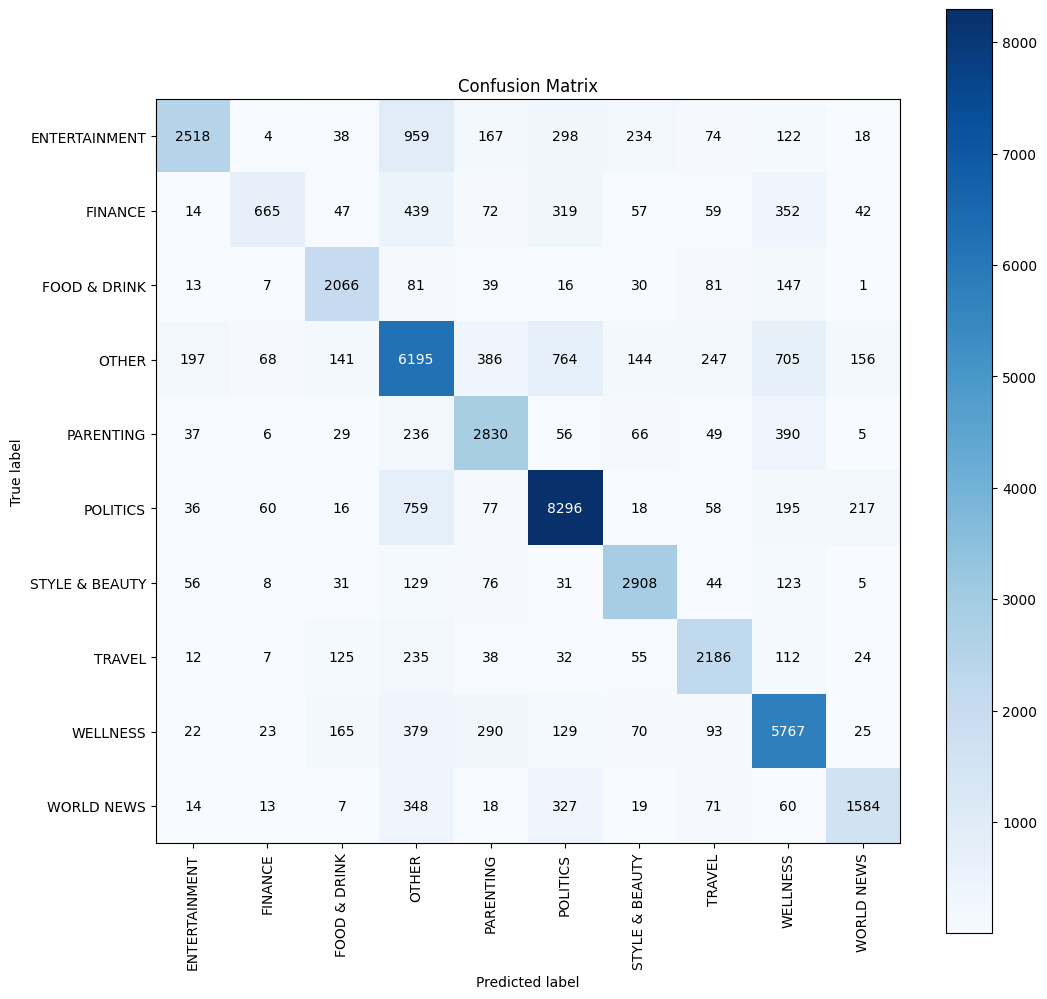

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
def predict_single(x):
    # lower the text
    x = x.lower()
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).to(DEVICE)

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

predict_single(data['full_review'].values[20])

<ipython-input-84-cbee0692f900>:12: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'ENTERTAINMENT'

In [ ]:
print("Train Accuracy : ",sum([predict_single(x)==y for x,y in zip(data['full_review'].values, data['category'].values)])/len(data))

<ipython-input-84-cbee0692f900>:12: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Train Accuracy :  0.784572739437966


In [ ]:
from graphviz import Digraph

dot = Digraph(comment='The EnhancedCNN_Text Model')

# Adding nodes (layers)
dot.node('A', 'Input Layer')
dot.node('B', 'Embedding Layer (18000, 300)')
dot.node('C', 'Convolutional Layer 1')
dot.node('D', 'Convolutional Layer 2')
dot.node('E', 'Convolutional Layer 3')
dot.node('F', 'Convolutional Layer 4')
dot.node('G', 'Convolutional Layer 5')
dot.node('H', 'Global Max Pooling')
dot.node('I', 'Dropout')
dot.node('J', 'Fully Connected Layer')
dot.node('K', 'Output Layer')

# Adding edges (connections)
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI', 'IJ', 'JK'])

# Visualize the graph
print(dot.source)
dot.render('test-output/EnhancedCNN_Text.gv', view=True)


// The EnhancedCNN_Text Model
digraph {
	A [label="Input Layer"]
	B [label="Embedding Layer (18000, 300)"]
	C [label="Convolutional Layer 1"]
	D [label="Convolutional Layer 2"]
	E [label="Convolutional Layer 3"]
	F [label="Convolutional Layer 4"]
	G [label="Convolutional Layer 5"]
	H [label="Global Max Pooling"]
	I [label=Dropout]
	J [label="Fully Connected Layer"]
	K [label="Output Layer"]
	A -> B
	B -> C
	C -> D
	D -> E
	E -> F
	F -> G
	G -> H
	H -> I
	I -> J
	J -> K
}



'test-output/EnhancedCNN_Text.gv.pdf'

In [ ]:
pip install diagrams


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.7/824.7 kB 71.7 MB/s eta 0:00:00


In [ ]:
from diagrams import Diagram, Cluster
from diagrams.onprem.client import Users
from diagrams.onprem.compute import Server

with Diagram("Enhanced CNN Text Classification", show=False, direction="TB"):

    # Input
    input_layer = Users("Input Text")

    # Embedding Layer
    embedding = Server("Embedding Layer\n(18000, 300)")

    # Convolutional Layers
    with Cluster("Convolutional Layers"):
        conv_layers = [Server(f"Conv Layer {i}\n(Conv2d, BatchNorm2d, LeakyReLU)") for i in range(1, 6)]

    # Global Max Pooling
    global_pool = Server("Global Max Pooling")

    # Dropout
    dropout = Server("Dropout (0.12)")

    # Fully Connected Layer
    fc_layer = Server("Fully Connected Layer\n(Linear)")

    # Output Layer
    output_layer = Server("Output Layer (Classification)")

    # Connecting layers
    input_layer >> embedding >> conv_layers[0]
    for i in range(4):
        conv_layers[i] >> conv_layers[i + 1]
    conv_layers[-1] >> global_pool >> dropout >> fc_layer >> output_layer


LSTM

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_size=64, dropout_rate=0.29764826566849856): #updated dropout_rate based on best params
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size * 4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005224824343509342) #updated lr based on best params

model.to(DEVICE)

batch_size = 512 # updated based on best params
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(DEVICE)
y_train = torch.tensor(train_y, dtype=torch.long).to(DEVICE)
x_cv = torch.tensor(test_X, dtype=torch.long).to(DEVICE)
y_cv = torch.tensor(test_y, dtype=torch.long).to(DEVICE)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-88-2ce3b591a8ac>:49: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/10 	 loss=573.1385 	 val_loss=391.7189  	 val_acc=0.7493  	 time=14.76s
Epoch 2/10 	 loss=400.5305 	 val_loss=372.0422  	 val_acc=0.7604  	 time=14.74s
Epoch 3/10 	 loss=363.4070 	 val_loss=364.8788  	 val_acc=0.7648  	 time=15.13s
Epoch 4/10 	 loss=336.5646 	 val_loss=366.9326  	 val_acc=0.7653  	 time=14.88s
Epoch 5/10 	 loss=313.5353 	 val_loss=372.4087  	 val_acc=0.7644  	 time=14.89s
Epoch 6/10 	 loss=292.4611 	 val_loss=387.0231  	 val_acc=0.7642  	 time=15.18s
Epoch 7/10 	 loss=273.1202 	 val_loss=393.2712  	 val_acc=0.7615  	 time=14.90s
Epoch 8/10 	 loss=254.4024 	 val_loss=406.8368  	 val_acc=0.7631  	 time=14.89s
Epoch 9/10 	 loss=236.7625 	 val_loss=420.7828  	 val_acc=0.7602  	 time=15.18s
Epoch 10/10 	 loss=222.6865 	 val_loss=429.0188  	 val_acc=0.7573  	 time=14.92s


In [ ]:
# Assuming 'data' is your DataFrame and 'category' is the target column
class_counts = data['category'].value_counts()
num_classes = 10  # As you have 10 classes

# Calculate class weights
class_weights = [data.shape[0] / (num_classes * class_counts[i]) for i in range(num_classes)]

# Convert to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


In [ ]:
from sklearn.metrics import accuracy_score

def train_model(trial):
    # Hyperparameters suggested by Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])

    model = BiLSTM(hidden_size=hidden_size, dropout_rate=dropout_rate)
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(5):  # Adjust number of epochs based on trial duration and model complexity
        model.train()
        for x_batch, y_batch in DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss(weight=class_weights)(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_preds = []
        with torch.no_grad():
            for x_batch, y_batch in DataLoader(TensorDataset(x_cv, y_cv), batch_size=batch_size):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                y_pred = model(x_batch)
                val_preds.extend(y_pred.argmax(dim=1).tolist())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(y_cv.cpu().numpy(), val_preds)

    return val_accuracy  # Return validation accuracy as the metric to optimize

def objective(trial):
    return train_model(trial)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=7200)  # Adjust the number of trials and timeout as needed

# Output the results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")





[I 2023-11-29 16:38:03,934] A new study created in memory with name: no-name-3c4458fd-8d1b-48ec-924f-99a4d90ee96a
[I 2023-11-29 16:39:20,127] Trial 0 finished with value: 0.7361243866692155 and parameters: {'lr': 0.0005896193700679242, 'hidden_size': 64, 'dropout_rate': 0.2320484298739781, 'batch_size': 256}. Best is trial 0 with value: 0.7361243866692155.
[I 2023-11-29 16:40:38,413] Trial 1 finished with value: 0.5251173559336435 and parameters: {'lr': 2.06166089996994e-05, 'hidden_size': 64, 'dropout_rate': 0.42360092182274744, 'batch_size': 64}. Best is trial 0 with value: 0.7361243866692155.
[I 2023-11-29 16:43:58,130] Trial 2 finished with value: 0.6994413645149642 and parameters: {'lr': 0.00012255482434363996, 'hidden_size': 128, 'dropout_rate': 0.4941912809505894, 'batch_size': 64}. Best is trial 0 with value: 0.7361243866692155.
[I 2023-11-29 16:47:08,445] Trial 3 finished with value: 0.731196499500839 and parameters: {'lr': 0.007319093895053385, 'hidden_size': 128, 'dropout_ra

Best trial:
 Value: 0.7505894347798382
 Params: 
    lr: 0.005224824343509342
    hidden_size: 64
    dropout_rate: 0.29764826566849856
    batch_size: 512


In [ ]:
print(model)

BiLSTM(
  (embedding): Embedding(18000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.29764826566849856, inplace=False)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
pip install torchsummary


In [ ]:
def model_summary(model, input_size, device='cuda'):
    print("Layer Name\t\tOutput Shape\t\tParam #")
    print("="*60)

    # Move model to the specified device
    model.to(device)
    model.eval()

    total_params = 0

    with torch.no_grad():
        x = torch.zeros(input_size, dtype=torch.long, device=device)  # Create a dummy input tensor
        for name, layer in model.named_modules():
            # Skip the container module
            if name == "":
                continue

            # Forward pass through the layer
            try:
                if isinstance(layer, nn.Embedding):
                    x = layer(x)  # Embedding layer expects LongTensor input
                elif isinstance(layer, (nn.LSTM, nn.GRU)):
                    x, _ = layer(x)
                else:
                    x = layer(x.float())  # Other layers expect FloatTensor input
            except Exception as e:
                x = torch.zeros(input_size, dtype=torch.long, device=device)  # Reset dummy input if layer fails

            output_shape = list(x.shape)
            num_params = sum(p.numel() for p in layer.parameters() if p.requires_grad)
            total_params += num_params

            print(f"{name}\t\t{output_shape}\t\t{num_params}")

    print(f"Total Params: {total_params}")

# Example usage
model_summary(model, input_size=(1, 300), device='cuda')



Layer Name		Output Shape		Param #
embedding		[1, 300, 300]		0
lstm		[1, 300]		187392
linear		[1, 300]		16448
relu		[1, 300]		0
dropout		[1, 300]		0
out		[1, 300]		650
Total Params: 204490


In [ ]:
torch.save(model,'bilstm_model')

                precision    recall  f1-score   support

 ENTERTAINMENT       0.76      0.76      0.76      4432
       FINANCE       0.61      0.57      0.59      2066
  FOOD & DRINK       0.82      0.79      0.81      2481
         OTHER       0.71      0.62      0.66      9003
     PARENTING       0.69      0.79      0.73      3704
      POLITICS       0.82      0.84      0.83      9732
STYLE & BEAUTY       0.83      0.85      0.84      3411
        TRAVEL       0.78      0.75      0.77      2826
      WELLNESS       0.76      0.82      0.78      6963
    WORLD NEWS       0.69      0.74      0.71      2461

      accuracy                           0.76     47079
     macro avg       0.75      0.75      0.75     47079
  weighted avg       0.76      0.76      0.76     47079



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

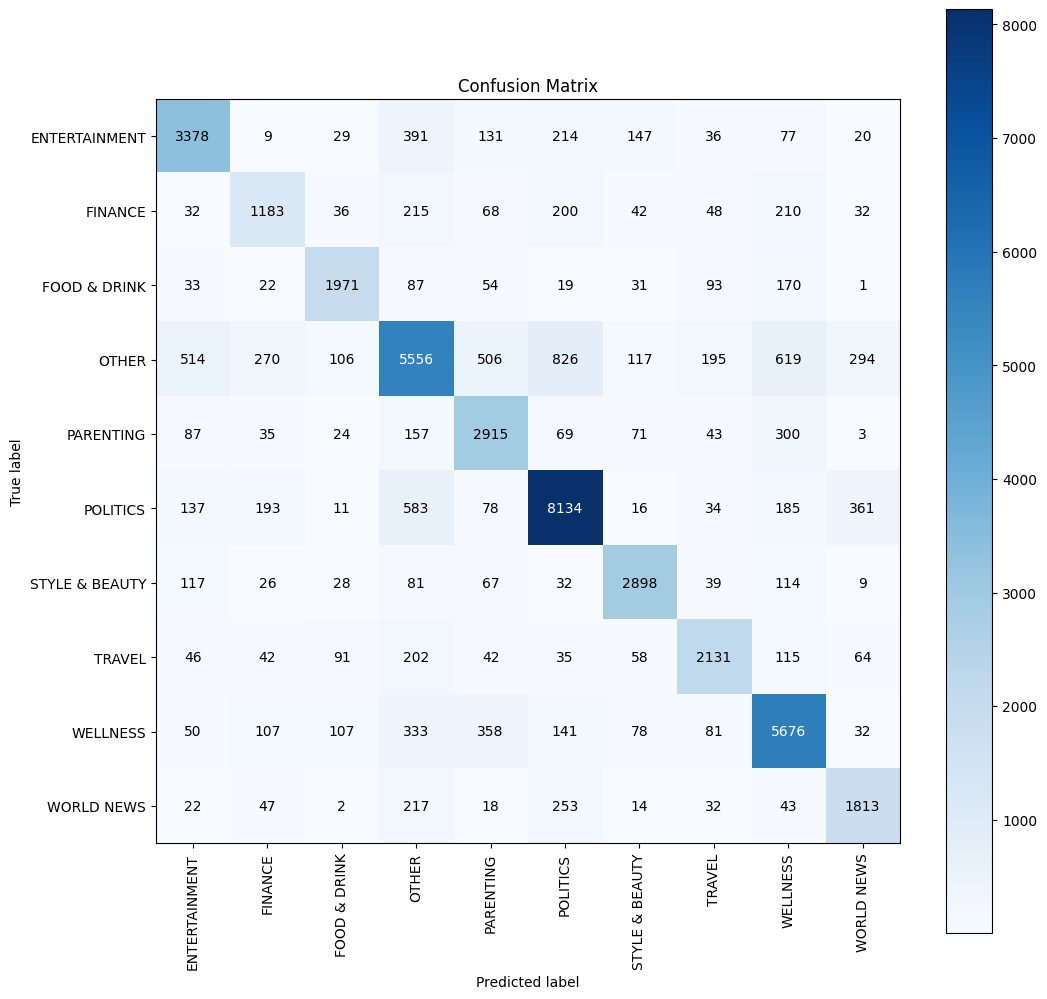

In [ ]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [ ]:
print("Train Accuracy : ",sum([predict_single(x)==y for x,y in zip(data['full_review'].values, data['category'].values)])/len(data))

<ipython-input-84-cbee0692f900>:12: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Train Accuracy :  0.8541579047983178


In [ ]:
print(model)

BiLSTM(
  (embedding): Embedding(18000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.29764826566849856, inplace=False)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
